# Fully-Connected Neural Nets
In the previous homework you implemented a fully-connected two-layer neural network on CIFAR-10. The implementation was simple but not very modular since the loss and gradient were computed in a single monolithic function. This is manageable for a simple two-layer network, but would become impractical as we move to bigger models. Ideally we want to build networks using a more modular design so that we can implement different layer types in isolation and then snap them together into models with different architectures.

In this exercise we will implement fully-connected networks using a more modular approach. For each layer we will implement a `forward` and a `backward` function. The `forward` function will receive inputs, weights, and other parameters and will return both an output and a `cache` object storing data needed for the backward pass, like this:

```python
def layer_forward(x, w):
  """ Receive inputs x and weights w """
  # Do some computations ...
  z = # ... some intermediate value
  # Do some more computations ...
  out = # the output
   
  cache = (x, w, z, out) # Values we need to compute gradients
   
  return out, cache
```

The backward pass will receive upstream derivatives and the `cache` object, and will return gradients with respect to the inputs and weights, like this:

```python
def layer_backward(dout, cache):
  """
  Receive derivative of loss with respect to outputs and cache,
  and compute derivative with respect to inputs.
  """
  # Unpack cache values
  x, w, z, out = cache
  
  # Use values in cache to compute derivatives
  dx = # Derivative of loss with respect to x
  dw = # Derivative of loss with respect to w
  
  return dx, dw
```

After implementing a bunch of layers this way, we will be able to easily combine them to build classifiers with different architectures.

In addition to implementing fully-connected networks of arbitrary depth, we will also explore different update rules for optimization, and introduce Dropout as a regularizer and Batch Normalization as a tool to more efficiently optimize deep networks.
  

In [1]:
# As usual, a bit of setup

import time
import numpy as np
import matplotlib.pyplot as plt
from cs231n.classifiers.fc_net import *
from cs231n.data_utils import get_CIFAR10_data
from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.solver import Solver

import pandas as pd
import seaborn as sns
sns.set_style("darkgrid")
# sns.set_context("talk")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [2]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in data.items():
    print('%s: ' % k, v.shape)

X_test:  (1000, 3, 32, 32)
X_train:  (49000, 3, 32, 32)
X_val:  (1000, 3, 32, 32)
y_val:  (1000,)
y_train:  (49000,)
y_test:  (1000,)


# Affine layer: foward
Open the file `cs231n/layers.py` and implement the `affine_forward` function.

Once you are done you can test your implementaion by running the following:

In [3]:
# Test the affine_forward function

num_inputs = 2
input_shape = (4, 5, 6)
output_dim = 3

input_size = num_inputs * np.prod(input_shape)
weight_size = output_dim * np.prod(input_shape)

x = np.linspace(-0.1, 0.5, num=input_size).reshape(num_inputs, *input_shape)
w = np.linspace(-0.2, 0.3, num=weight_size).reshape(np.prod(input_shape), output_dim)
b = np.linspace(-0.3, 0.1, num=output_dim)

out, _ = affine_forward(x, w, b)
correct_out = np.array([[ 1.49834967,  1.70660132,  1.91485297],
                        [ 3.25553199,  3.5141327,   3.77273342]])

# Compare your output with ours. The error should be around 1e-9.
print('Testing affine_forward function:')
print('difference: ', rel_error(out, correct_out))

assert out.shape == correct_out.shape

Testing affine_forward function:
difference:  9.76985004799e-10


# Affine layer: backward
Now implement the `affine_backward` function and test your implementation using numeric gradient checking.

In [4]:
# Test the affine_backward function

x = np.random.randn(10, 2, 3)
w = np.random.randn(6, 5)
b = np.random.randn(5)
dout = np.random.randn(10, 5)

dx_num = eval_numerical_gradient_array(lambda x: affine_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_forward(x, w, b)[0], b, dout)

_, cache = affine_forward(x, w, b)
dx, dw, db = affine_backward(dout, cache)

# The error should be around 1e-10
print('Testing affine_backward function:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

assert dx.shape == dx.shape
assert dw.shape == dw.shape
assert db.shape == db.shape

Testing affine_backward function:
dx error:  9.72796680667e-11
dw error:  3.9058697528e-11
db error:  5.0832788679e-11


# ReLU layer: forward
Implement the forward pass for the ReLU activation function in the `relu_forward` function and test your implementation using the following:

In [5]:
# Test the relu_forward function

x = np.linspace(-0.5, 0.5, num=12).reshape(3, 4)

out, _ = relu_forward(x)
correct_out = np.array([[ 0.,          0.,          0.,          0.,        ],
                        [ 0.,          0.,          0.04545455,  0.13636364,],
                        [ 0.22727273,  0.31818182,  0.40909091,  0.5,       ]])

# Compare your output with ours. The error should be around 1e-8
print('Testing relu_forward function:')
print('difference: ', rel_error(out, correct_out))

assert out.shape == correct_out.shape

#better check
x = np.random.randn(5,5)
out1 , _ = relu_forward(x)
x[x<0] = 0
print(out1 -x)
np.linalg.norm(out1 - x)

for x in range(1,8):
    testing_shape = []
    for y in range(1,x+1):
        testing_shape.append(np.random.randint(3,8))
    shape = tuple(testing_shape)
    #y = np.random.randn(*testing_shape)
    x = np.random.standard_normal(shape)
    assert x.shape == relu_forward(x)[0].shape
    x[x<0] = 0
    print(x.shape)
    print(np.linalg.norm(x - relu_forward(x)[0]))

Testing relu_forward function:
difference:  4.99999979802e-08
[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]]
(4,)
0.0
(3, 7)
0.0
(6, 3, 7)
0.0
(3, 6, 6, 4)
0.0
(7, 3, 4, 3, 3)
0.0
(3, 7, 4, 6, 6, 3)
0.0
(4, 3, 5, 4, 6, 6, 3)
0.0


# ReLU layer: backward
Now implement the backward pass for the ReLU activation function in the `relu_backward` function and test your implementation using numeric gradient checking:

In [6]:
x = np.random.randn(10, 10)
dout = np.random.randn(*x.shape)

dx_num = eval_numerical_gradient_array(lambda x: relu_forward(x)[0], x, dout)

_, cache = relu_forward(x)
dx = relu_backward(dout, cache)

# The error should be around 1e-12
print('Testing relu_backward function:')
print('dx error: ', rel_error(dx_num, dx))

assert dx.shape == dx_num.shape
assert dout.shape == x.shape

Testing relu_backward function:
dx error:  3.27563866248e-12


# "Sandwich" layers
There are some common patterns of layers that are frequently used in neural nets. For example, affine layers are frequently followed by a ReLU nonlinearity. To make these common patterns easy, we define several convenience layers in the file `cs231n/layer_utils.py`.

For now take a look at the `affine_relu_forward` and `affine_relu_backward` functions, and run the following to numerically gradient check the backward pass:

In [7]:
from cs231n.layer_utils import affine_relu_forward, affine_relu_backward

x = np.random.randn(2, 3, 4)
w = np.random.randn(12, 10)

b = np.random.randn(10)
dout = np.random.randn(2, 10)

out, cache = affine_relu_forward(x, w, b)
dx, dw, db = affine_relu_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: affine_relu_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_relu_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_relu_forward(x, w, b)[0], b, dout)

print('Testing affine_relu_forward:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

assert dx.shape == dx_num.shape
assert dw.shape == dw_num.shape
assert db.shape == db_num.shape

assert out.shape == dout.shape

Testing affine_relu_forward:
dx error:  3.61876954649e-10
dw error:  4.92127202931e-11
db error:  6.39682584131e-11


# Loss layers: Softmax and SVM
You implemented these loss functions in the last assignment, so we'll give them to you for free here. You should still make sure you understand how they work by looking at the implementations in `cs231n/layers.py`.

You can make sure that the implementations are correct by running the following:

In [8]:
num_classes, num_inputs = 10, 50
x = 0.001 * np.random.randn(num_inputs, num_classes)
y = np.random.randint(num_classes, size=num_inputs)

dx_num = eval_numerical_gradient(lambda x: svm_loss(x, y)[0], x, verbose=False)
loss, dx = svm_loss(x, y)

# Test svm_loss function. Loss should be around 9 and dx error should be 1e-9
print('Testing svm_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))

dx_num = eval_numerical_gradient(lambda x: softmax_loss(x, y)[0], x, verbose=False)
loss, dx = softmax_loss(x, y)

# Test softmax_loss function. Loss should be 2.3 and dx error should be 1e-8
print('\nTesting softmax_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))

assert dx.shape == dx_num.shape
assert y.shape[0] == dx.shape[0]

Testing svm_loss:
loss:  8.99992776551
dx error:  1.40215660067e-09

Testing softmax_loss:
loss:  2.30257833281
dx error:  1.08127701138e-08


# Two-layer network
In the previous assignment you implemented a two-layer neural network in a single monolithic class. Now that you have implemented modular versions of the necessary layers, you will reimplement the two layer network using these modular implementations.

Open the file `cs231n/classifiers/fc_net.py` and complete the implementation of the `TwoLayerNet` class. This class will serve as a model for the other networks you will implement in this assignment, so read through it to make sure you understand the API. You can run the cell below to test your implementation.

In [9]:
N, D, H, C = 3, 5, 50, 7
X = np.random.randn(N, D)
y = np.random.randint(C, size=N)

std = 1e-2
model = TwoLayerNet(input_dim=D, hidden_dim=H, num_classes=C, weight_scale=std)

print('Testing initialization ... ')
W1_std = abs(model.params['W1'].std() - std)
b1 = model.params['b1']
W2_std = abs(model.params['W2'].std() - std)
b2 = model.params['b2']
assert W1_std < std / 10, 'First layer weights do not seem right'
assert np.all(b1 == 0), 'First layer biases do not seem right'
assert W2_std < std / 10, 'Second layer weights do not seem right'
assert np.all(b2 == 0), 'Second layer biases do not seem right'

print('Testing test-time forward pass ... ')
model.params['W1'] = np.linspace(-0.7, 0.3, num=D*H).reshape(D, H)
model.params['b1'] = np.linspace(-0.1, 0.9, num=H)
model.params['W2'] = np.linspace(-0.3, 0.4, num=H*C).reshape(H, C)
model.params['b2'] = np.linspace(-0.9, 0.1, num=C)
X = np.linspace(-5.5, 4.5, num=N*D).reshape(D, N).T
scores = model.loss(X)
correct_scores = np.asarray(
  [[11.53165108,  12.2917344,   13.05181771,  13.81190102,  14.57198434, 15.33206765,  16.09215096],
   [12.05769098,  12.74614105,  13.43459113,  14.1230412,   14.81149128, 15.49994135,  16.18839143],
   [12.58373087,  13.20054771,  13.81736455,  14.43418138,  15.05099822, 15.66781506,  16.2846319 ]])
scores_diff = np.abs(scores - correct_scores).sum()

assert scores.shape == correct_scores.shape
assert scores_diff < 1e-6, 'Problem with test-time forward pass'

print('Testing training loss (no regularization)')
y = np.asarray([0, 5, 1])
loss, grads = model.loss(X, y)
correct_loss = 3.4702243556
assert abs(loss - correct_loss) < 1e-10, 'Problem with training-time loss'

model.reg = 1.0
loss, grads = model.loss(X, y)
correct_loss = 26.5948426952
assert abs(loss - correct_loss) < 1e-10, 'Problem with regularization loss'

for reg in [0.0, 0.7]:
    print('Running numeric gradient check with reg = ', reg)
    model.reg = reg
    loss, grads = model.loss(X, y)

    for name in sorted(grads):
        f = lambda _: model.loss(X, y)[0]
        grad_num = eval_numerical_gradient(f, model.params[name], verbose=False)
        print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))
        assert grad_num.shape == grads[name].shape
        assert grads[name].shape == model.params[name].shape

Testing initialization ... 
Testing test-time forward pass ... 
Testing training loss (no regularization)
Running numeric gradient check with reg =  0.0
W1 relative error: 1.52e-08
W2 relative error: 3.50e-10
b1 relative error: 6.55e-09
b2 relative error: 5.96e-10
Running numeric gradient check with reg =  0.7
W1 relative error: 8.18e-07
W2 relative error: 2.85e-08
b1 relative error: 1.35e-08
b2 relative error: 1.97e-09


# Solver
In the previous assignment, the logic for training models was coupled to the models themselves. Following a more modular design, for this assignment we have split the logic for training models into a separate class.

Open the file `cs231n/solver.py` and read through it to familiarize yourself with the API. After doing so, use a `Solver` instance to train a `TwoLayerNet` that achieves at least `50%` accuracy on the validation set.

In [10]:
model = TwoLayerNet(input_dim=3*32*32, hidden_dim=256, num_classes=10, weight_scale=0.001)
solver = Solver(model=model, data=data,
                update_rule='sgd', optim_config={'learning_rate' : 1e-3}, lr_decay=0.90, 
                num_epochs=10, batch_size=200,
                print_every=100, verbose=True)

##############################################################################
# TODO: Use a Solver instance to train a TwoLayerNet that achieves at least  #
# 50% accuracy on the validation set.                                        #
##############################################################################
solver.train()
solver.optim_config['learning_rate'] = 1e-4
solver.lr_decay = 0.95
solver.train()
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

(Iteration 1 / 2450) loss: 2.297946
(Epoch 0 / 10) train acc: 0.141000; val_acc: 0.151000
(Iteration 101 / 2450) loss: 1.706564
(Iteration 201 / 2450) loss: 1.598389
Shuffling Training Data (end of epoch task);
(Epoch 1 / 10) train acc: 0.457000; val_acc: 0.451000
(Iteration 301 / 2450) loss: 1.674150
(Iteration 401 / 2450) loss: 1.457241
Shuffling Training Data (end of epoch task);
(Epoch 2 / 10) train acc: 0.492000; val_acc: 0.487000
(Iteration 501 / 2450) loss: 1.513656
(Iteration 601 / 2450) loss: 1.327929
(Iteration 701 / 2450) loss: 1.521101
Shuffling Training Data (end of epoch task);
(Epoch 3 / 10) train acc: 0.512000; val_acc: 0.480000
(Iteration 801 / 2450) loss: 1.365625
(Iteration 901 / 2450) loss: 1.440334
Shuffling Training Data (end of epoch task);
(Epoch 4 / 10) train acc: 0.535000; val_acc: 0.503000
(Iteration 1001 / 2450) loss: 1.243085
(Iteration 1101 / 2450) loss: 1.278408
(Iteration 1201 / 2450) loss: 1.306465
Shuffling Training Data (end of epoch task);
(Epoch 5 /

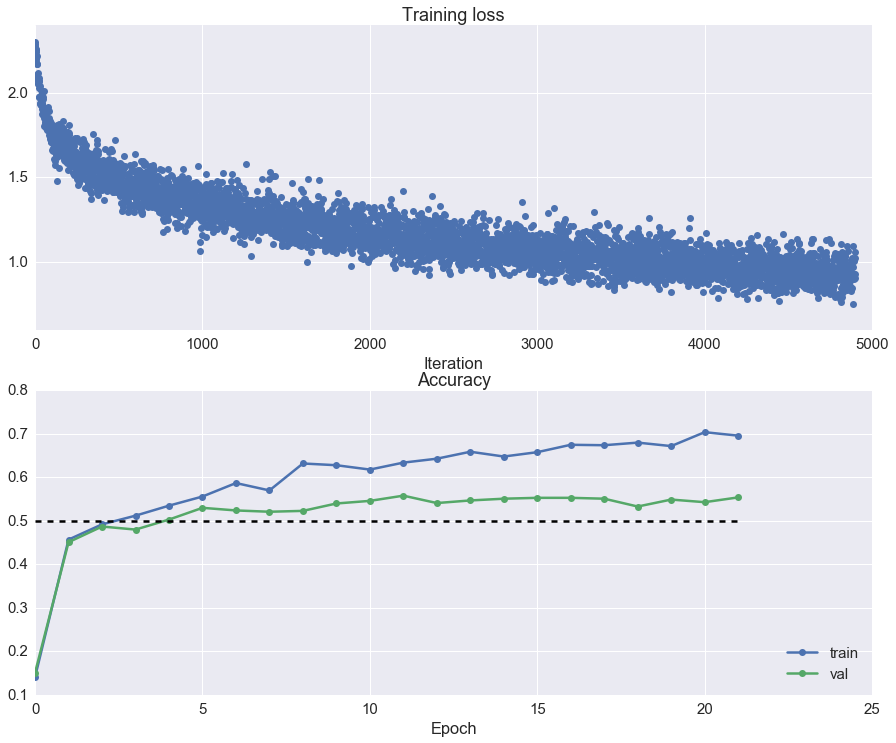

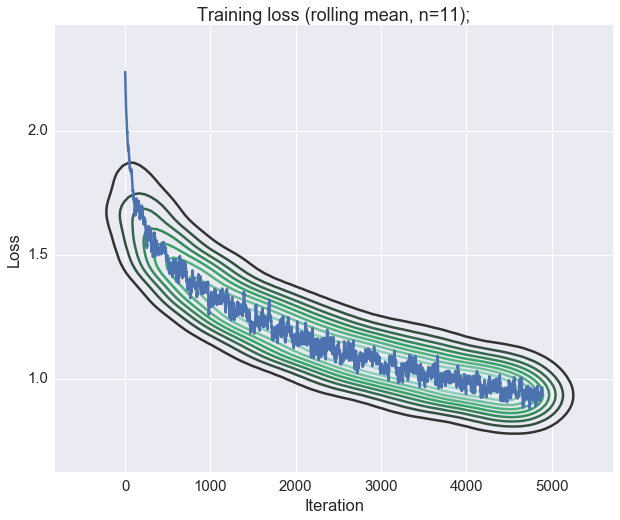

In [11]:
# Run this cell to visualize training loss and train / val accuracy

plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(solver.loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(solver.train_acc_history, '-o', label='train')
plt.plot(solver.val_acc_history, '-o', label='val')
plt.plot([0.5] * len(solver.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

#
#d = {'iteration' : x, 'loss' : y}

x = np.arange(len(solver.loss_history))
y = np.array(solver.loss_history)
x_s = pd.Series(x, name='iteration')
y_s = pd.Series(y, name='loss')
df = pd.concat([x_s,y_s], axis=1)

df_mean = df.rolling(window=11,center=True).mean()
df_mean = df_mean.dropna(how='all')

plt.figure()
x = np.arange(len(solver.loss_history))
y = np.array(solver.loss_history)
sns.kdeplot(data=x, data2=y)
y_rolling = df_mean['loss'].values
plt.plot(y_rolling)
plt.title('Training loss (rolling mean, n=11);')
plt.xlabel('Iteration')
plt.ylabel('Loss')



# Multilayer network
Next you will implement a fully-connected network with an arbitrary number of hidden layers.

Read through the `FullyConnectedNet` class in the file `cs231n/classifiers/fc_net.py`.

Implement the initialization, the forward pass, and the backward pass. For the moment don't worry about implementing dropout or batch normalization; we will add those features soon.

## Initial loss and gradient check

As a sanity check, run the following to check the initial loss and to gradient check the network both with and without regularization. Do the initial losses seem reasonable?

For gradient checking, you should expect to see errors around 1e-6 or less.

In [12]:
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for reg in [0, 3.14]:
    print('Running check with reg = ', reg)
    model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                            reg=reg, weight_scale=5e-2, dtype=np.float64)

    loss, grads = model.loss(X, y)
    print('Initial loss: ', loss)

    for name in sorted(grads):
        f = lambda _: model.loss(X, y)[0]
        grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
        print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Running check with reg =  0
Initial loss:  2.3091717717
('W', 0) relative error: 1.45e-07
('W', 1) relative error: 1.87e-06
('W', 2) relative error: 1.99e-07
('b', 0) relative error: 3.95e-09
('b', 1) relative error: 2.74e-09
('b', 2) relative error: 1.38e-10
Running check with reg =  3.14
Initial loss:  7.03325112602
('W', 0) relative error: 2.10e-08
('W', 1) relative error: 2.62e-08
('W', 2) relative error: 1.00e-06
('b', 0) relative error: 2.28e-07
('b', 1) relative error: 1.18e-08
('b', 2) relative error: 1.78e-10


As another sanity check, make sure you can overfit a small dataset of 50 images. First we will try a three-layer network with 100 units in each hidden layer. You will need to tweak the learning rate and initialization scale, but you should be able to overfit and achieve 100% training accuracy within 20 epochs.

(Iteration 1 / 40) loss: 32.420398
(Epoch 0 / 20) train acc: 0.240000; val_acc: 0.090000
Shuffling Training Data (end of epoch task);
(Epoch 1 / 20) train acc: 0.320000; val_acc: 0.124000
Shuffling Training Data (end of epoch task);
(Epoch 2 / 20) train acc: 0.380000; val_acc: 0.108000
Shuffling Training Data (end of epoch task);
(Epoch 3 / 20) train acc: 0.820000; val_acc: 0.118000
Shuffling Training Data (end of epoch task);
(Epoch 4 / 20) train acc: 0.920000; val_acc: 0.126000
Shuffling Training Data (end of epoch task);
(Epoch 5 / 20) train acc: 0.980000; val_acc: 0.130000
(Iteration 11 / 40) loss: 0.001241
Shuffling Training Data (end of epoch task);
(Epoch 6 / 20) train acc: 1.000000; val_acc: 0.125000
Shuffling Training Data (end of epoch task);
(Epoch 7 / 20) train acc: 1.000000; val_acc: 0.125000
Shuffling Training Data (end of epoch task);
(Epoch 8 / 20) train acc: 1.000000; val_acc: 0.125000
Shuffling Training Data (end of epoch task);
(Epoch 9 / 20) train acc: 1.000000; val

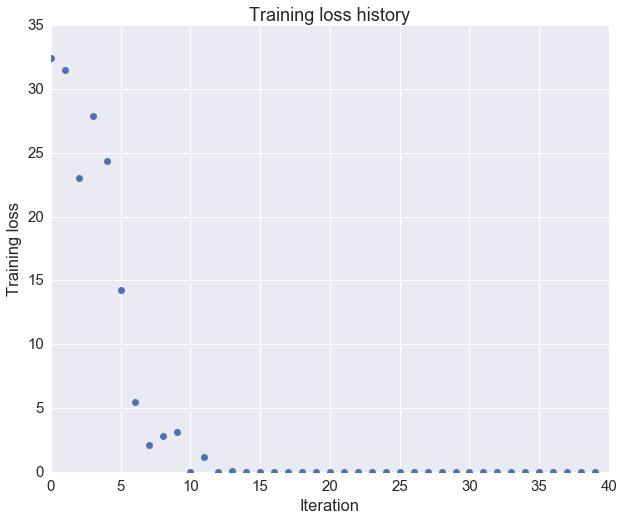

In [13]:
# TODO: Use a three-layer Net to overfit 50 training examples.

num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

weight_scale = 1e-1
learning_rate = 1e-3
model = FullyConnectedNet([100, 100],
              weight_scale=weight_scale, dtype=np.float64)
solver = Solver(model, small_data,
                print_every=10, num_epochs=20, batch_size=25,
                update_rule='sgd',
                optim_config={
                  'learning_rate': learning_rate,
                }
         )
solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

Now try to use a five-layer network with 100 units on each layer to overfit 50 training examples. Again you will have to adjust the learning rate and weight initialization, but you should be able to achieve 100% training accuracy within 20 epochs.

(Iteration 1 / 40) loss: 28.468323
(Epoch 0 / 20) train acc: 0.180000; val_acc: 0.077000
Shuffling Training Data (end of epoch task);
(Epoch 1 / 20) train acc: 0.200000; val_acc: 0.096000
Shuffling Training Data (end of epoch task);
(Epoch 2 / 20) train acc: 0.360000; val_acc: 0.090000
Shuffling Training Data (end of epoch task);
(Epoch 3 / 20) train acc: 0.700000; val_acc: 0.099000
Shuffling Training Data (end of epoch task);
(Epoch 4 / 20) train acc: 0.860000; val_acc: 0.091000
Shuffling Training Data (end of epoch task);
(Epoch 5 / 20) train acc: 0.980000; val_acc: 0.090000
(Iteration 11 / 40) loss: 0.185011
Shuffling Training Data (end of epoch task);
(Epoch 6 / 20) train acc: 1.000000; val_acc: 0.090000
Shuffling Training Data (end of epoch task);
(Epoch 7 / 20) train acc: 1.000000; val_acc: 0.090000
Shuffling Training Data (end of epoch task);
(Epoch 8 / 20) train acc: 1.000000; val_acc: 0.090000
Shuffling Training Data (end of epoch task);
(Epoch 9 / 20) train acc: 1.000000; val

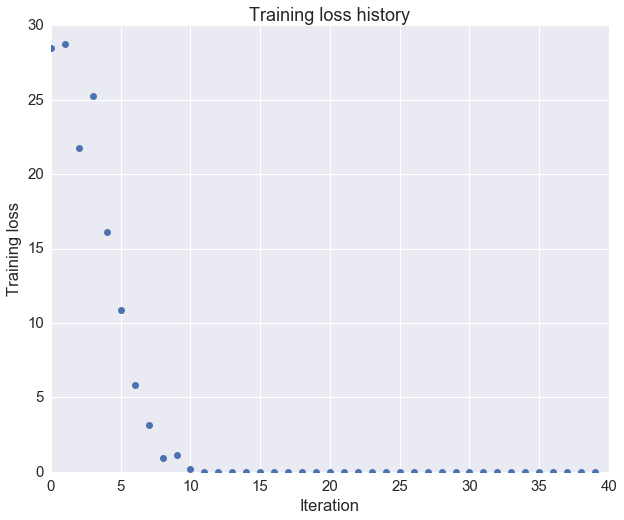

In [14]:
# TODO: Use a five-layer Net to overfit 50 training examples.

num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

weight_scale = 1e-1
learning_rate = 1e-3
model = FullyConnectedNet([100, 100, 100, 100],
                weight_scale=weight_scale, dtype=np.float64)
solver = Solver(model, small_data,
                print_every=10, num_epochs=20, batch_size=25,
                update_rule='sgd',
                optim_config={
                  'learning_rate': learning_rate,
                }
         )
solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

# Inline question: 
Did you notice anything about the comparative difficulty of training the three-layer net vs training the five layer net?

# Answer:
The higher the number of layers the less number of iterations it required to overfit.

# Update rules
So far we have used vanilla stochastic gradient descent (SGD) as our update rule. More sophisticated update rules can make it easier to train deep networks. We will implement a few of the most commonly used update rules and compare them to vanilla SGD.

# SGD+Momentum
Stochastic gradient descent with momentum is a widely used update rule that tends to make deep networks converge faster than vanilla stochstic gradient descent.

Open the file `cs231n/optim.py` and read the documentation at the top of the file to make sure you understand the API. Implement the SGD+momentum update rule in the function `sgd_momentum` and run the following to check your implementation. You should see errors less than 1e-8.

In [15]:
from cs231n.optim import sgd_momentum

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
v = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-3, 'velocity': v}
next_w, _ = sgd_momentum(w, dw, config=config)

expected_next_w = np.asarray([
  [ 0.1406,      0.20738947,  0.27417895,  0.34096842,  0.40775789],
  [ 0.47454737,  0.54133684,  0.60812632,  0.67491579,  0.74170526],
  [ 0.80849474,  0.87528421,  0.94207368,  1.00886316,  1.07565263],
  [ 1.14244211,  1.20923158,  1.27602105,  1.34281053,  1.4096    ]])
expected_velocity = np.asarray([
  [ 0.5406,      0.55475789,  0.56891579, 0.58307368,  0.59723158],
  [ 0.61138947,  0.62554737,  0.63970526,  0.65386316,  0.66802105],
  [ 0.68217895,  0.69633684,  0.71049474,  0.72465263,  0.73881053],
  [ 0.75296842,  0.76712632,  0.78128421,  0.79544211,  0.8096    ]])

print('next_w error: ', rel_error(next_w, expected_next_w))
print('velocity error: ', rel_error(expected_velocity, config['velocity']))

assert next_w.shape == expected_next_w.shape

next_w error:  8.88234703351e-09
velocity error:  4.26928774328e-09


Once you have done so, run the following to train a six-layer network with both SGD and SGD+momentum. You should see the SGD+momentum update rule converge faster.

running with  sgd
(Iteration 1 / 800) loss: 2.819981
(Epoch 0 / 20) train acc: 0.115000; val_acc: 0.087000
Shuffling Training Data (end of epoch task);
(Epoch 1 / 20) train acc: 0.100000; val_acc: 0.088000
Shuffling Training Data (end of epoch task);
(Epoch 2 / 20) train acc: 0.101000; val_acc: 0.101000
(Iteration 101 / 800) loss: 2.446607
Shuffling Training Data (end of epoch task);
(Epoch 3 / 20) train acc: 0.102000; val_acc: 0.101000
Shuffling Training Data (end of epoch task);
(Epoch 4 / 20) train acc: 0.108000; val_acc: 0.107000
Shuffling Training Data (end of epoch task);
(Epoch 5 / 20) train acc: 0.090000; val_acc: 0.106000
(Iteration 201 / 800) loss: 2.312846
Shuffling Training Data (end of epoch task);
(Epoch 6 / 20) train acc: 0.118000; val_acc: 0.109000
Shuffling Training Data (end of epoch task);
(Epoch 7 / 20) train acc: 0.134000; val_acc: 0.116000
(Iteration 301 / 800) loss: 2.312945
Shuffling Training Data (end of epoch task);
(Epoch 8 / 20) train acc: 0.115000; val_acc:

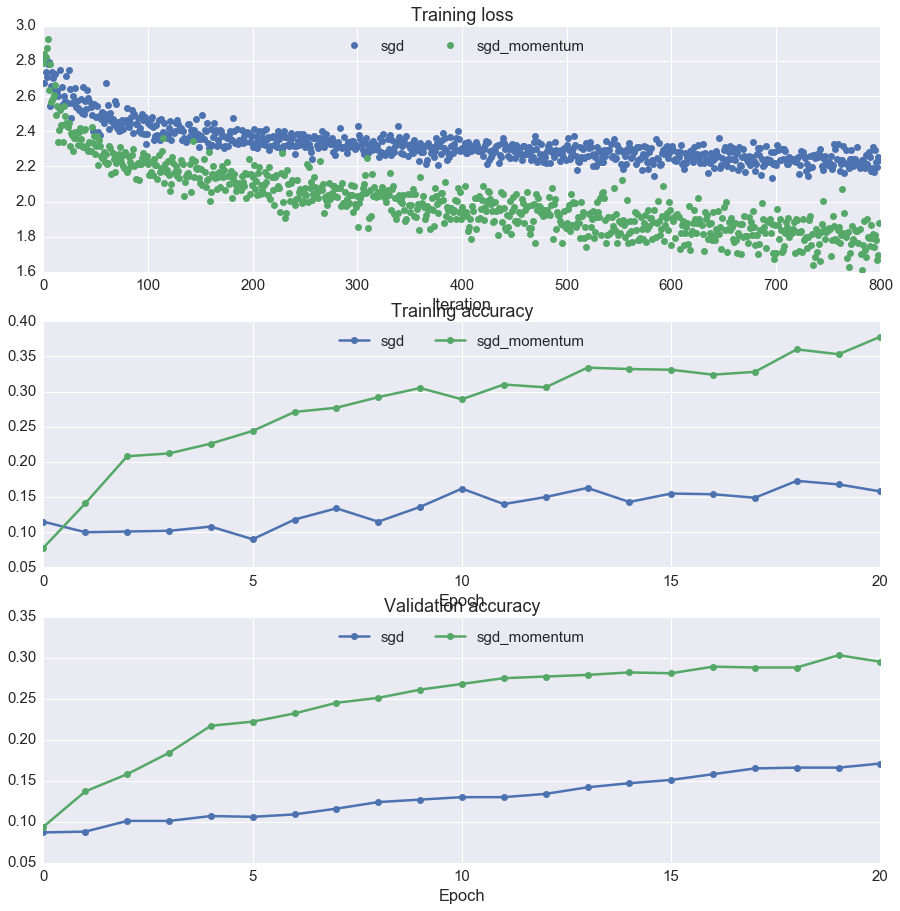

In [16]:
num_train = 4000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}

for update_rule in ['sgd', 'sgd_momentum']:
    print('running with ', update_rule)
    model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=5e-2)

    solver = Solver(model, small_data,
                  num_epochs=20, batch_size=100,
                  update_rule=update_rule,
                  optim_config={
                    'learning_rate': 1e-4,
                  },
                  print_every=100,
                  verbose=True)
    solvers[update_rule] = solver
    solver.train()

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for update_rule, solver in solvers.items():
    plt.subplot(3, 1, 1)
    plt.plot(solver.loss_history, 'o', label=update_rule)

    plt.subplot(3, 1, 2)
    plt.plot(solver.train_acc_history, '-o', label=update_rule)

    plt.subplot(3, 1, 3)
    plt.plot(solver.val_acc_history, '-o', label=update_rule)

for i in [1, 2, 3]:
    plt.subplot(3, 1, i)
    plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

running with  adawindow
(Iteration 1 / 800) loss: 2.651289
(Epoch 0 / 20) train acc: 0.117000; val_acc: 0.108000
(Iteration 21 / 800) loss: 2.237573
Shuffling Training Data (end of epoch task);
(Epoch 1 / 20) train acc: 0.208000; val_acc: 0.192000
(Iteration 41 / 800) loss: 2.171185
(Iteration 61 / 800) loss: 2.064836
Shuffling Training Data (end of epoch task);
(Epoch 2 / 20) train acc: 0.267000; val_acc: 0.235000
(Iteration 81 / 800) loss: 2.112662
(Iteration 101 / 800) loss: 2.031148
Shuffling Training Data (end of epoch task);
(Epoch 3 / 20) train acc: 0.264000; val_acc: 0.254000
(Iteration 121 / 800) loss: 2.074264
(Iteration 141 / 800) loss: 2.089447
Shuffling Training Data (end of epoch task);
(Epoch 4 / 20) train acc: 0.291000; val_acc: 0.257000
(Iteration 161 / 800) loss: 1.978579
(Iteration 181 / 800) loss: 2.016375
Shuffling Training Data (end of epoch task);
(Epoch 5 / 20) train acc: 0.327000; val_acc: 0.268000
(Iteration 201 / 800) loss: 1.909605
(Iteration 221 / 800) loss

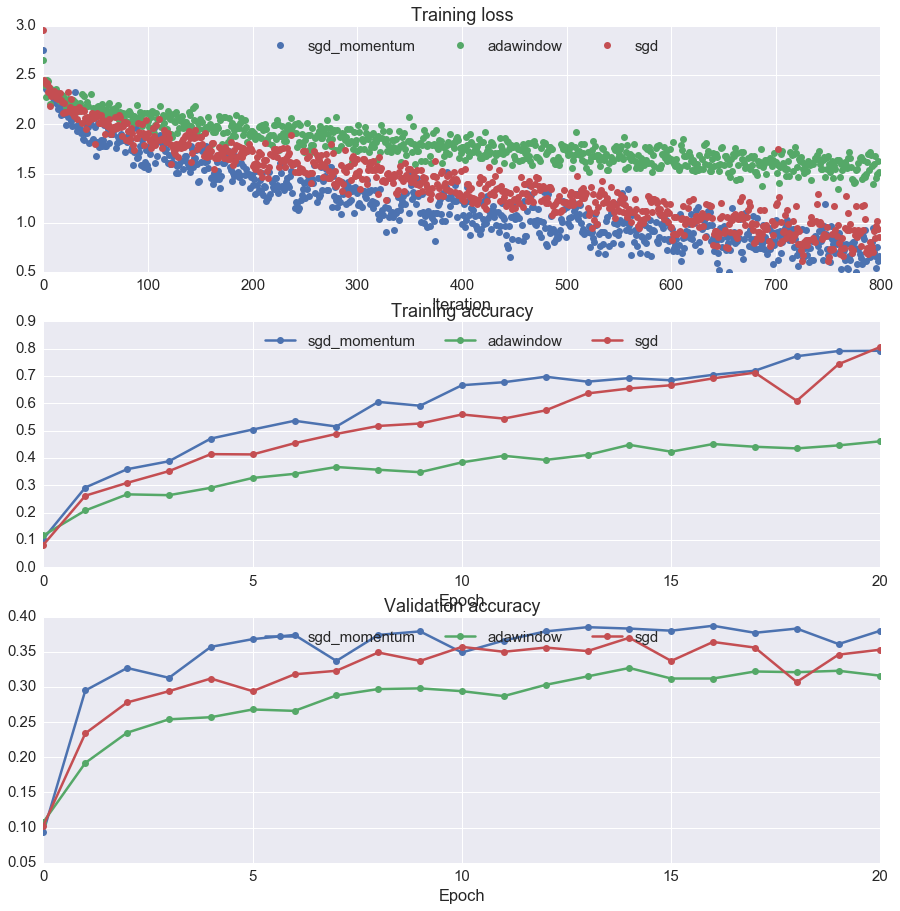

In [17]:
#TESTING Adawindow (keeps a rolling window of 100 gradients); very slow;
from cs231n.optim import adawindow

num_train = 4000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}

learning_rates = {'sgd_momentum': 1e-2, 'adawindow': 0.01, 'sgd' : 0.01}

for update_rule in [ 'adawindow', 'sgd_momentum', 'sgd']:
    print('running with ', update_rule)
    model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=5e-2, reg=0.0)

    solver = Solver(model, small_data,
                  num_epochs=20, batch_size=100,
                  update_rule=update_rule,
                  optim_config={
                    'learning_rate': learning_rates[update_rule],
                  },
                  print_every=20,
                  verbose=True)
    solvers[update_rule] = solver
    solver.train()

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for update_rule, solver in solvers.items():
    plt.subplot(3, 1, 1)
    plt.plot(solver.loss_history, 'o', label=update_rule)

    plt.subplot(3, 1, 2)
    plt.plot(solver.train_acc_history, '-o', label=update_rule)

    plt.subplot(3, 1, 3)
    plt.plot(solver.val_acc_history, '-o', label=update_rule)

for i in [1, 2, 3]:
    plt.subplot(3, 1, i)
    plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

# RMSProp and Adam
RMSProp [1] and Adam [2] are update rules that set per-parameter learning rates by using a running average of the second moments of gradients.

In the file `cs231n/optim.py`, implement the RMSProp update rule in the `rmsprop` function and implement the Adam update rule in the `adam` function, and check your implementations using the tests below.

[1] Tijmen Tieleman and Geoffrey Hinton. "Lecture 6.5-rmsprop: Divide the gradient by a running average of its recent magnitude." COURSERA: Neural Networks for Machine Learning 4 (2012).

[2] Diederik Kingma and Jimmy Ba, "Adam: A Method for Stochastic Optimization", ICLR 2015.

In [18]:
# Test RMSProp implementation; you should see errors less than 1e-7
from cs231n.optim import rmsprop

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
cache = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'cache': cache}
next_w, _ = rmsprop(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.39223849, -0.34037513, -0.28849239, -0.23659121, -0.18467247],
  [-0.132737,   -0.08078555, -0.02881884,  0.02316247,  0.07515774],
  [ 0.12716641,  0.17918792,  0.23122175,  0.28326742,  0.33532447],
  [ 0.38739248,  0.43947102,  0.49155973,  0.54365823,  0.59576619]])
expected_cache = np.asarray([
  [ 0.5976,      0.6126277,   0.6277108,   0.64284931,  0.65804321],
  [ 0.67329252,  0.68859723,  0.70395734,  0.71937285,  0.73484377],
  [ 0.75037008,  0.7659518,   0.78158892,  0.79728144,  0.81302936],
  [ 0.82883269,  0.84469141,  0.86060554,  0.87657507,  0.8926    ]])

print('next_w error: ', rel_error(expected_next_w, next_w))
print('cache error: ', rel_error(expected_cache, config['cache']))

assert expected_next_w.shape == w.shape
assert expected_cache.shape == config['cache'].shape

next_w error:  9.50264522989e-08
cache error:  2.64779558072e-09


In [19]:
# Test Adam implementation; you should see errors around 1e-7 or less
from cs231n.optim import adam

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
m = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)
v = np.linspace(0.7, 0.5, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'm': m, 'v': v, 't': 5}
next_w, _ = adam(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.40094747, -0.34836187, -0.29577703, -0.24319299, -0.19060977],
  [-0.1380274,  -0.08544591, -0.03286534,  0.01971428,  0.0722929],
  [ 0.1248705,   0.17744702,  0.23002243,  0.28259667,  0.33516969],
  [ 0.38774145,  0.44031188,  0.49288093,  0.54544852,  0.59801459]])
expected_v = np.asarray([
  [ 0.69966,     0.68908382,  0.67851319,  0.66794809,  0.65738853,],
  [ 0.64683452,  0.63628604,  0.6257431,   0.61520571,  0.60467385,],
  [ 0.59414753,  0.58362676,  0.57311152,  0.56260183,  0.55209767,],
  [ 0.54159906,  0.53110598,  0.52061845,  0.51013645,  0.49966,   ]])
expected_m = np.asarray([
  [ 0.48,        0.49947368,  0.51894737,  0.53842105,  0.55789474],
  [ 0.57736842,  0.59684211,  0.61631579,  0.63578947,  0.65526316],
  [ 0.67473684,  0.69421053,  0.71368421,  0.73315789,  0.75263158],
  [ 0.77210526,  0.79157895,  0.81105263,  0.83052632,  0.85      ]])

print('next_w error: ', rel_error(expected_next_w, next_w))
print('v error: ', rel_error(expected_v, config['v']))
print('m error: ', rel_error(expected_m, config['m']))

assert expected_next_w.shape == w.shape
assert expected_v.shape == v.shape
assert expected_m.shape == m.shape

next_w error:  1.13956917985e-07
v error:  4.20831403811e-09
m error:  4.21496319311e-09


Once you have debugged your RMSProp and Adam implementations, run the following to train a pair of deep networks using these new update rules:

running with  adam
(Iteration 1 / 800) loss: 2.515059
(Epoch 0 / 20) train acc: 0.084000; val_acc: 0.095000
Shuffling Training Data (end of epoch task);
(Epoch 1 / 20) train acc: 0.269000; val_acc: 0.207000
Shuffling Training Data (end of epoch task);
(Epoch 2 / 20) train acc: 0.352000; val_acc: 0.284000
(Iteration 101 / 800) loss: 1.732717
Shuffling Training Data (end of epoch task);
(Epoch 3 / 20) train acc: 0.394000; val_acc: 0.321000
Shuffling Training Data (end of epoch task);
(Epoch 4 / 20) train acc: 0.425000; val_acc: 0.344000
Shuffling Training Data (end of epoch task);
(Epoch 5 / 20) train acc: 0.484000; val_acc: 0.338000
(Iteration 201 / 800) loss: 1.626061
Shuffling Training Data (end of epoch task);
(Epoch 6 / 20) train acc: 0.494000; val_acc: 0.356000
Shuffling Training Data (end of epoch task);
(Epoch 7 / 20) train acc: 0.555000; val_acc: 0.357000
(Iteration 301 / 800) loss: 1.347591
Shuffling Training Data (end of epoch task);
(Epoch 8 / 20) train acc: 0.575000; val_acc

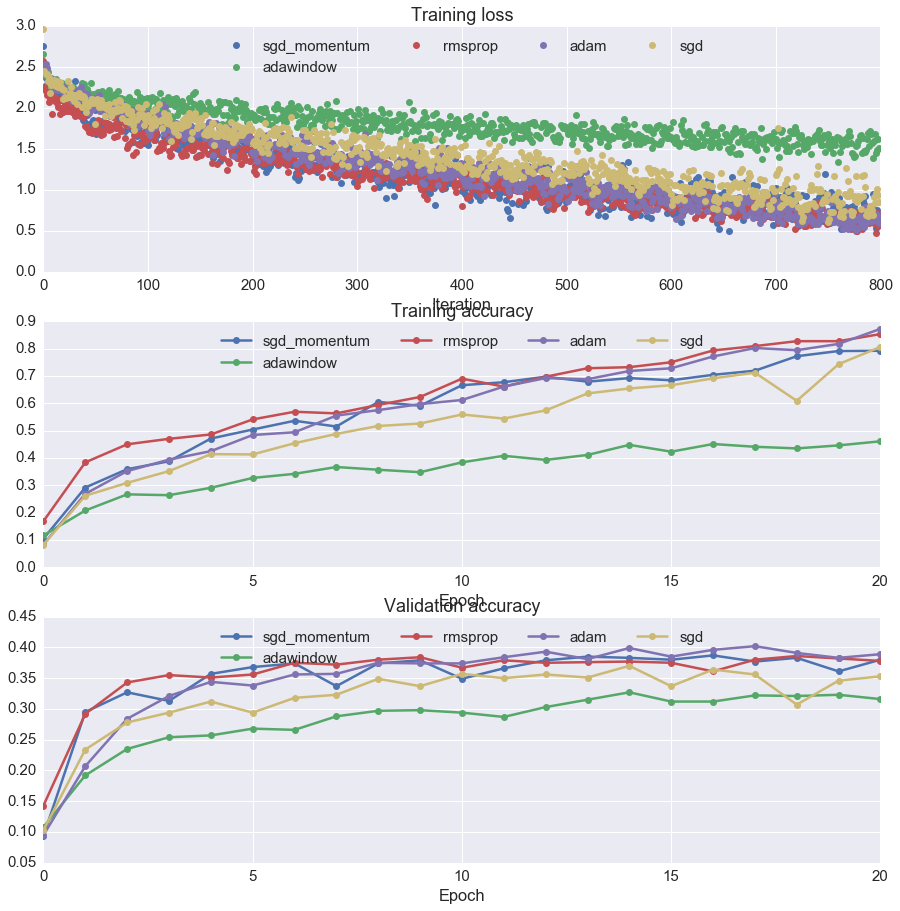

In [20]:
learning_rates = {'rmsprop': 1e-4, 'adam': 1e-4}

for update_rule in ['adam', 'rmsprop']:
    print('running with ', update_rule)
    model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=5e-2)
    
    solver = Solver(model, small_data,
                  num_epochs=20, batch_size=100,
                  update_rule=update_rule,
                  optim_config={
                    'learning_rate': learning_rates[update_rule]
                  },
                  print_every=100,
                  verbose=True)
    solvers[update_rule] = solver
    solver.train()

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for update_rule, solver in solvers.items():
    plt.subplot(3, 1, 1)
    plt.plot(solver.loss_history, 'o', label=update_rule)

    plt.subplot(3, 1, 2)
    plt.plot(solver.train_acc_history, '-o', label=update_rule)

    plt.subplot(3, 1, 3)
    plt.plot(solver.val_acc_history, '-o', label=update_rule)

for i in [1, 2, 3]:
    plt.subplot(3, 1, i)
    plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

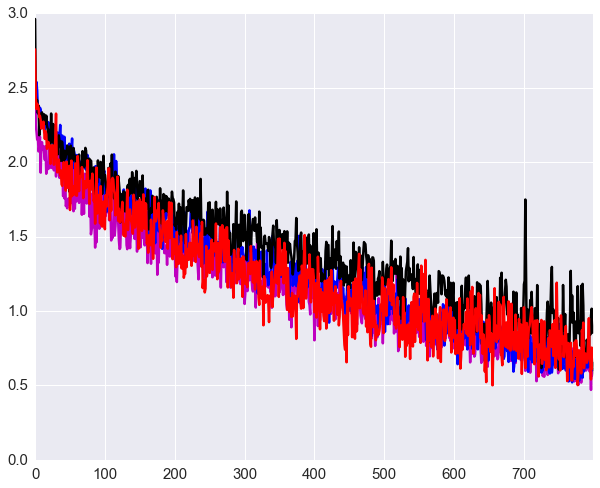

In [21]:
import seaborn as sns

y = np.array(solvers['rmsprop'].loss_history)
z = np.array(solvers['adam'].loss_history)
s = np.array(solvers['sgd'].loss_history)
s_m = np.array(solvers['sgd_momentum'].loss_history)
ax = sns.tsplot(data=y, ci=[68, 95], color="m")
sns.tsplot(data=z, ci=[68, 95], color="b", ax=ax)
sns.tsplot(data=s, ci=[68, 95], color="k", ax=ax)
sns.tsplot(data=s_m, ci=[68, 95], color="r", ax=ax)


In [22]:
solvers_multi = {}
learning_rates = {'rmsprop':1e-4, 'adam': 1e-4, 'sgd_momentum': 1e-4}
for i in range(0,15):
    for update_rule in ['rmsprop', 'sgd_momentum', 'adam']:
        if i == 0:
            solvers_multi[update_rule] = []
        print('running with ', update_rule)
        model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=5e-2, seed=i)

        solver = Solver(model, small_data,
                        num_epochs=25, batch_size=100,
                        update_rule=update_rule,
                        optim_config={
                          'learning_rate': learning_rates[update_rule]
                        },
                        print_every=100,
                        verbose=True)
        solvers_multi[update_rule].append(solver)
        solver.train()
        print("Done Training ",i)


running with  rmsprop
(Iteration 1 / 1000) loss: 2.733831
(Epoch 0 / 25) train acc: 0.120000; val_acc: 0.101000
Shuffling Training Data (end of epoch task);
(Epoch 1 / 25) train acc: 0.386000; val_acc: 0.309000
Shuffling Training Data (end of epoch task);
(Epoch 2 / 25) train acc: 0.433000; val_acc: 0.338000
(Iteration 101 / 1000) loss: 1.563076
Shuffling Training Data (end of epoch task);
(Epoch 3 / 25) train acc: 0.466000; val_acc: 0.342000
Shuffling Training Data (end of epoch task);
(Epoch 4 / 25) train acc: 0.499000; val_acc: 0.349000
Shuffling Training Data (end of epoch task);
(Epoch 5 / 25) train acc: 0.557000; val_acc: 0.361000
(Iteration 201 / 1000) loss: 1.383528
Shuffling Training Data (end of epoch task);
(Epoch 6 / 25) train acc: 0.556000; val_acc: 0.360000
Shuffling Training Data (end of epoch task);
(Epoch 7 / 25) train acc: 0.587000; val_acc: 0.376000
(Iteration 301 / 1000) loss: 1.157293
Shuffling Training Data (end of epoch task);
(Epoch 8 / 25) train acc: 0.638000; 

[(1.5, 3.5), (0, 25)]

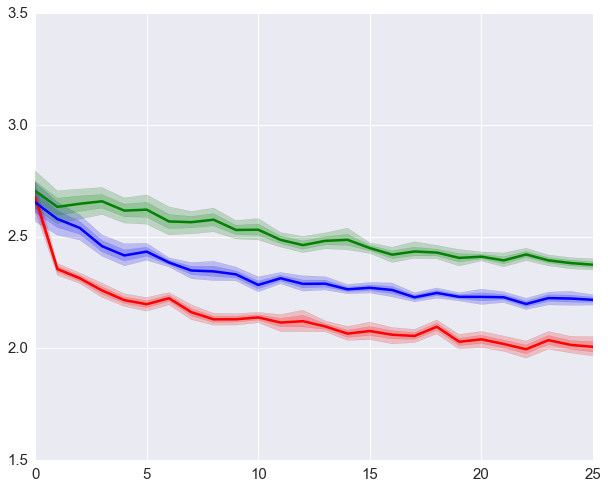

In [23]:
y = []
z = []
s = []

for solver in solvers_multi['rmsprop']:
    y.append(solver.loss_history)
for solver in solvers_multi['adam']:
    z.append(solver.loss_history)
for solver in solvers_multi['sgd_momentum']:
    s.append(solver.loss_history)

rms_loss_array = np.array(y)
adam_loss_array = np.array(z)
sgd_mom_loss_array = np.array(s)

ax = sns.tsplot(data=rms_loss_array, interpolate=True, color="r", ci=[68,95])
sns.tsplot(data=adam_loss_array, interpolate=True, color="b", ci=[68,95])
sns.tsplot(data=sgd_mom_loss_array, interpolate=True, color="g", ci=[68,95])
ax.set(xlim=(0, 25), ylim=(1.5, 3.5))

# Train a good model!
Train the best fully-connected model that you can on CIFAR-10, storing your best model in the `best_model` variable. We require you to get at least 50% accuracy on the validation set using a fully-connected net.

If you are careful it should be possible to get accuracies above 55%, but we don't require it for this part and won't assign extra credit for doing so. Later in the assignment we will ask you to train the best convolutional network that you can on CIFAR-10, and we would prefer that you spend your effort working on convolutional nets rather than fully-connected nets.

You might find it useful to complete the `BatchNormalization.ipynb` and `Dropout.ipynb` notebooks before completing this part, since those techniques can help you train powerful models.

In [24]:
best_model = None
################################################################################
# TODO: Train the best FullyConnectedNet that you can on CIFAR-10. You might   #
# batch normalization and dropout useful. Store your best model in the         #
# best_model variable.                                                         #
################################################################################
model = FullyConnectedNet([512, 256], input_dim=3*32*32, num_classes=10,
                            reg=0, weight_scale=5e-4, dropout = 0.75, dtype=np.float32, use_batchnorm=True)

solver = Solver(model=model, data=data,
                update_rule='adam', optim_config={'learning_rate' : 1e-2}, lr_decay=0.90, 
                num_epochs=20, batch_size=1000,
                print_every=25, verbose=True)

solver.train()
solver.optim_config['learning_rate'] = 1e-4
solver.lr_decay = 0.95
solver.train()
solver.optim_config['learning_rate'] = 1e-5
solver.lr_decay = 0.95
solver.train()
solver.optim_config['learning_rate'] = 1e-6
solver.lr_decay = 0.95
solver.train()
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

(Iteration 1 / 980) loss: 2.302404
(Epoch 0 / 20) train acc: 0.090000; val_acc: 0.078000
(Iteration 26 / 980) loss: 1.796648
Shuffling Training Data (end of epoch task);
(Epoch 1 / 20) train acc: 0.416000; val_acc: 0.417000
(Iteration 51 / 980) loss: 1.652834
(Iteration 76 / 980) loss: 1.549122
Shuffling Training Data (end of epoch task);
(Epoch 2 / 20) train acc: 0.458000; val_acc: 0.480000
(Iteration 101 / 980) loss: 1.516806
(Iteration 126 / 980) loss: 1.448671
Shuffling Training Data (end of epoch task);
(Epoch 3 / 20) train acc: 0.533000; val_acc: 0.512000
(Iteration 151 / 980) loss: 1.411995
(Iteration 176 / 980) loss: 1.362450
Shuffling Training Data (end of epoch task);
(Epoch 4 / 20) train acc: 0.540000; val_acc: 0.538000
(Iteration 201 / 980) loss: 1.312232
(Iteration 226 / 980) loss: 1.300743
Shuffling Training Data (end of epoch task);
(Epoch 5 / 20) train acc: 0.558000; val_acc: 0.533000
(Iteration 251 / 980) loss: 1.346122
(Iteration 276 / 980) loss: 1.262550
Shuffling Tr

# Test you model
Run your best model on the validation and test sets. You should achieve above 50% accuracy on the validation set.

In [25]:
solver.batch_size = 5000
solver.optim_config['learning_rate'] = 1e-4
model.dropout = 0.50
solver.lr_decay = 0.99
num_epochs=20
solver.train()

(Iteration 1 / 180) loss: 0.453685
(Epoch 80 / 20) train acc: 0.915000; val_acc: 0.578000
(Epoch 81 / 20) train acc: 0.922000; val_acc: 0.578000
Shuffling Training Data (end of epoch task);
(Epoch 82 / 20) train acc: 0.911000; val_acc: 0.580000
Shuffling Training Data (end of epoch task);
(Iteration 26 / 180) loss: 0.437863
(Epoch 83 / 20) train acc: 0.923000; val_acc: 0.579000
Shuffling Training Data (end of epoch task);
(Epoch 84 / 20) train acc: 0.931000; val_acc: 0.579000
Shuffling Training Data (end of epoch task);
(Epoch 85 / 20) train acc: 0.927000; val_acc: 0.579000
Shuffling Training Data (end of epoch task);
(Iteration 51 / 180) loss: 0.453342
(Epoch 86 / 20) train acc: 0.915000; val_acc: 0.579000
Shuffling Training Data (end of epoch task);
(Epoch 87 / 20) train acc: 0.937000; val_acc: 0.578000
Shuffling Training Data (end of epoch task);
(Epoch 88 / 20) train acc: 0.925000; val_acc: 0.577000
(Iteration 76 / 180) loss: 0.459811
Shuffling Training Data (end of epoch task);
(E

In [26]:
solver.batch_size = 500
solver.optim_config['learning_rate'] = 1e-4
solver.lr_decay = 0.90
model.dropout = 0.25
solver.num_epochs=20
solver.train()

(Iteration 1 / 1960) loss: 0.442248
(Epoch 100 / 20) train acc: 0.904000; val_acc: 0.580000
(Iteration 26 / 1960) loss: 0.423476
(Iteration 51 / 1960) loss: 0.444049
(Iteration 76 / 1960) loss: 0.505883
Shuffling Training Data (end of epoch task);
(Epoch 101 / 20) train acc: 0.927000; val_acc: 0.578000
(Iteration 101 / 1960) loss: 0.464711
(Iteration 126 / 1960) loss: 0.453730
(Iteration 151 / 1960) loss: 0.381157
(Iteration 176 / 1960) loss: 0.512709
Shuffling Training Data (end of epoch task);
(Epoch 102 / 20) train acc: 0.935000; val_acc: 0.582000
(Iteration 201 / 1960) loss: 0.403543
(Iteration 226 / 1960) loss: 0.540973
(Iteration 251 / 1960) loss: 0.467027
(Iteration 276 / 1960) loss: 0.493612
Shuffling Training Data (end of epoch task);
(Epoch 103 / 20) train acc: 0.899000; val_acc: 0.582000
(Iteration 301 / 1960) loss: 0.450704
(Iteration 326 / 1960) loss: 0.436771
(Iteration 351 / 1960) loss: 0.508652
(Iteration 376 / 1960) loss: 0.436392
Shuffling Training Data (end of epoch 

In [27]:
best_model = model
y_test_pred = np.argmax(best_model.loss(data['X_test']), axis=1)
y_val_pred = np.argmax(best_model.loss(data['X_val']), axis=1)
print('Validation set accuracy: ', (y_val_pred == data['y_val']).mean())
print('Test set accuracy: ', (y_test_pred == data['y_test']).mean())

Validation set accuracy:  0.588
Test set accuracy:  0.576


In [28]:
solver.batch_size = 300
solver.optim_config['learning_rate'] = 1e-2
solver.train()

(Iteration 1 / 3260) loss: 0.509515
(Epoch 120 / 20) train acc: 0.904000; val_acc: 0.583000
(Iteration 26 / 3260) loss: 0.446324
(Iteration 51 / 3260) loss: 0.475485
(Iteration 76 / 3260) loss: 0.563624
(Iteration 101 / 3260) loss: 0.428095
(Iteration 126 / 3260) loss: 0.352534
(Iteration 151 / 3260) loss: 0.511265
(Epoch 121 / 20) train acc: 0.912000; val_acc: 0.583000
Shuffling Training Data (end of epoch task);
(Iteration 176 / 3260) loss: 0.528709
(Iteration 201 / 3260) loss: 0.444242
(Iteration 226 / 3260) loss: 0.462757
(Iteration 251 / 3260) loss: 0.549818
(Iteration 276 / 3260) loss: 0.548560
(Iteration 301 / 3260) loss: 0.455330
(Iteration 326 / 3260) loss: 0.441992
(Epoch 122 / 20) train acc: 0.934000; val_acc: 0.585000
Shuffling Training Data (end of epoch task);
(Iteration 351 / 3260) loss: 0.487780
(Iteration 376 / 3260) loss: 0.572653
(Iteration 401 / 3260) loss: 0.450573
(Iteration 426 / 3260) loss: 0.414310
(Iteration 451 / 3260) loss: 0.542859
(Iteration 476 / 3260) lo

In [29]:
best_model = model
y_test_pred = np.argmax(best_model.loss(data['X_test']), axis=1)
y_val_pred = np.argmax(best_model.loss(data['X_val']), axis=1)
print('Validation set accuracy: ', (y_val_pred == data['y_val']).mean())
print('Test set accuracy: ', (y_test_pred == data['y_test']).mean())

Validation set accuracy:  0.586
Test set accuracy:  0.575


In [30]:
model.params[('W',0)]

array([[-0.01191021,  0.0830061 ,  0.14031315, ...,  0.12358349,
         0.07520464,  0.24797244],
       [ 0.02077142,  0.08815278,  0.46432668, ...,  0.12839427,
         0.03639987, -0.01659771],
       [-0.01124441,  0.09348809,  0.58338607, ...,  0.08988048,
        -0.15262701, -0.15775361],
       ..., 
       [-0.15013029,  0.05069668,  0.18990877, ..., -0.12124652,
         0.01206381,  0.51852508],
       [-0.20483539,  0.05046818,  0.06610872, ..., -0.08337161,
         0.06894593,  0.61782609],
       [-0.23783821,  0.05683638,  0.03682616, ..., -0.06176066,
         0.29339614,  0.73394905]])

In [31]:
model_2 = FullyConnectedNet([512, 256, 128], input_dim=3*32*32, num_classes=10,
                            reg=0, weight_scale=5e-1, dropout = 0.5, dtype=np.float32, use_batchnorm=True)
model_2.params[('W',0)] = np.copy(model.params[('W',0)])
model_2.params[('b',0)] = np.copy(model.params[('b',0)])

solver = Solver(model=model_2, data=data,
                update_rule='adam', optim_config={'learning_rate' : 1e-2}, lr_decay=0.90, 
                num_epochs=20, batch_size=1000,
                print_every=25, verbose=True)
solver.train()
solver.optim_config['learning_rate'] = 1e-2
solver.train()
solver.optim_config['learning_rate'] = 1e-3
solver.train()
solver.optim_config['learning_rate'] = 1e-4
solver.train()

(Iteration 1 / 980) loss: 9.531892
(Epoch 0 / 20) train acc: 0.169000; val_acc: 0.154000
(Iteration 26 / 980) loss: 3.592756
Shuffling Training Data (end of epoch task);
(Epoch 1 / 20) train acc: 0.366000; val_acc: 0.350000
(Iteration 51 / 980) loss: 2.433441
(Iteration 76 / 980) loss: 2.094643
Shuffling Training Data (end of epoch task);
(Epoch 2 / 20) train acc: 0.370000; val_acc: 0.373000
(Iteration 101 / 980) loss: 1.995734
(Iteration 126 / 980) loss: 1.898724
Shuffling Training Data (end of epoch task);
(Epoch 3 / 20) train acc: 0.398000; val_acc: 0.393000
(Iteration 151 / 980) loss: 1.825395
(Iteration 176 / 980) loss: 1.801244
Shuffling Training Data (end of epoch task);
(Epoch 4 / 20) train acc: 0.409000; val_acc: 0.420000
(Iteration 201 / 980) loss: 1.822251
(Iteration 226 / 980) loss: 1.783032
Shuffling Training Data (end of epoch task);
(Epoch 5 / 20) train acc: 0.427000; val_acc: 0.432000
(Iteration 251 / 980) loss: 1.744088
(Iteration 276 / 980) loss: 1.662684
Shuffling Tr

In [32]:
solver.optim_config['learning_rate'] = 1e-4
solver.train()

(Iteration 1 / 980) loss: 1.411155
(Epoch 80 / 20) train acc: 0.557000; val_acc: 0.513000
(Iteration 26 / 980) loss: 1.408040
Shuffling Training Data (end of epoch task);
(Epoch 81 / 20) train acc: 0.582000; val_acc: 0.513000
(Iteration 51 / 980) loss: 1.402896
(Iteration 76 / 980) loss: 1.371413
Shuffling Training Data (end of epoch task);
(Epoch 82 / 20) train acc: 0.546000; val_acc: 0.513000
(Iteration 101 / 980) loss: 1.366269
(Iteration 126 / 980) loss: 1.335834
Shuffling Training Data (end of epoch task);
(Epoch 83 / 20) train acc: 0.578000; val_acc: 0.513000
(Iteration 151 / 980) loss: 1.420573
(Iteration 176 / 980) loss: 1.423871
Shuffling Training Data (end of epoch task);
(Epoch 84 / 20) train acc: 0.582000; val_acc: 0.513000
(Iteration 201 / 980) loss: 1.379086
(Iteration 226 / 980) loss: 1.448918
Shuffling Training Data (end of epoch task);
(Epoch 85 / 20) train acc: 0.564000; val_acc: 0.513000
(Iteration 251 / 980) loss: 1.384768
(Iteration 276 / 980) loss: 1.384210
Shuffl

In [33]:
solver.optim_config['learning_rate'] = 1e-5
solver.train()

(Iteration 1 / 980) loss: 1.369197
(Epoch 100 / 20) train acc: 0.571000; val_acc: 0.513000
(Iteration 26 / 980) loss: 1.393008
Shuffling Training Data (end of epoch task);
(Epoch 101 / 20) train acc: 0.568000; val_acc: 0.513000
(Iteration 51 / 980) loss: 1.367535
(Iteration 76 / 980) loss: 1.390886
Shuffling Training Data (end of epoch task);
(Epoch 102 / 20) train acc: 0.586000; val_acc: 0.513000
(Iteration 101 / 980) loss: 1.419108
(Iteration 126 / 980) loss: 1.366949
Shuffling Training Data (end of epoch task);
(Epoch 103 / 20) train acc: 0.574000; val_acc: 0.513000
(Iteration 151 / 980) loss: 1.361754
(Iteration 176 / 980) loss: 1.409063
Shuffling Training Data (end of epoch task);
(Epoch 104 / 20) train acc: 0.581000; val_acc: 0.513000
(Iteration 201 / 980) loss: 1.370746
(Iteration 226 / 980) loss: 1.404709
Shuffling Training Data (end of epoch task);
(Epoch 105 / 20) train acc: 0.583000; val_acc: 0.513000
(Iteration 251 / 980) loss: 1.359450
(Iteration 276 / 980) loss: 1.373575


In [34]:
solver.optim_config['learning_rate'] = 1e-4
model_2.dropout = 0.25
solver.train()

(Iteration 1 / 980) loss: 1.404808
(Epoch 120 / 20) train acc: 0.570000; val_acc: 0.513000
(Iteration 26 / 980) loss: 1.352646
Shuffling Training Data (end of epoch task);
(Epoch 121 / 20) train acc: 0.592000; val_acc: 0.513000
(Iteration 51 / 980) loss: 1.339126
(Iteration 76 / 980) loss: 1.344558
Shuffling Training Data (end of epoch task);
(Epoch 122 / 20) train acc: 0.569000; val_acc: 0.513000
(Iteration 101 / 980) loss: 1.363975
(Iteration 126 / 980) loss: 1.369878
Shuffling Training Data (end of epoch task);
(Epoch 123 / 20) train acc: 0.575000; val_acc: 0.513000
(Iteration 151 / 980) loss: 1.385555
(Iteration 176 / 980) loss: 1.374509
Shuffling Training Data (end of epoch task);
(Epoch 124 / 20) train acc: 0.562000; val_acc: 0.513000
(Iteration 201 / 980) loss: 1.360071
(Iteration 226 / 980) loss: 1.419565
Shuffling Training Data (end of epoch task);
(Epoch 125 / 20) train acc: 0.590000; val_acc: 0.513000
(Iteration 251 / 980) loss: 1.409568
(Iteration 276 / 980) loss: 1.400093


In [35]:
solver.optim_config['learning_rate'] = 1e-3
model_2.dropout = 0.25
solver.train()

(Iteration 1 / 980) loss: 1.332662
(Epoch 140 / 20) train acc: 0.572000; val_acc: 0.513000
(Iteration 26 / 980) loss: 1.415771
Shuffling Training Data (end of epoch task);
(Epoch 141 / 20) train acc: 0.572000; val_acc: 0.513000
(Iteration 51 / 980) loss: 1.405613
(Iteration 76 / 980) loss: 1.390055
Shuffling Training Data (end of epoch task);
(Epoch 142 / 20) train acc: 0.577000; val_acc: 0.513000
(Iteration 101 / 980) loss: 1.387152
(Iteration 126 / 980) loss: 1.365812
Shuffling Training Data (end of epoch task);
(Epoch 143 / 20) train acc: 0.569000; val_acc: 0.513000
(Iteration 151 / 980) loss: 1.420511
(Iteration 176 / 980) loss: 1.388066
Shuffling Training Data (end of epoch task);
(Epoch 144 / 20) train acc: 0.588000; val_acc: 0.513000
(Iteration 201 / 980) loss: 1.382104
(Iteration 226 / 980) loss: 1.324430
Shuffling Training Data (end of epoch task);
(Epoch 145 / 20) train acc: 0.562000; val_acc: 0.513000
(Iteration 251 / 980) loss: 1.398725
(Iteration 276 / 980) loss: 1.360520


In [36]:
solver.optim_config['learning_rate'] = 1e-4
model_2.dropout = 0.1
solver.train()

(Iteration 1 / 980) loss: 1.370439
(Epoch 160 / 20) train acc: 0.549000; val_acc: 0.513000
(Iteration 26 / 980) loss: 1.352652
Shuffling Training Data (end of epoch task);
(Epoch 161 / 20) train acc: 0.564000; val_acc: 0.513000
(Iteration 51 / 980) loss: 1.343316
(Iteration 76 / 980) loss: 1.407349
Shuffling Training Data (end of epoch task);
(Epoch 162 / 20) train acc: 0.575000; val_acc: 0.513000
(Iteration 101 / 980) loss: 1.341582
(Iteration 126 / 980) loss: 1.390672
Shuffling Training Data (end of epoch task);
(Epoch 163 / 20) train acc: 0.578000; val_acc: 0.513000
(Iteration 151 / 980) loss: 1.423717
(Iteration 176 / 980) loss: 1.378395
Shuffling Training Data (end of epoch task);
(Epoch 164 / 20) train acc: 0.574000; val_acc: 0.513000
(Iteration 201 / 980) loss: 1.408849
(Iteration 226 / 980) loss: 1.357008
Shuffling Training Data (end of epoch task);
(Epoch 165 / 20) train acc: 0.558000; val_acc: 0.513000
(Iteration 251 / 980) loss: 1.331650
(Iteration 276 / 980) loss: 1.322517


In [38]:
y_test_pred = np.argmax(model_2.loss(data['X_test']), axis=1)
y_val_pred = np.argmax(model_2.loss(data['X_val']), axis=1)
print('Validation set accuracy: ', (y_val_pred == data['y_val']).mean())
print('Test set accuracy: ', (y_test_pred == data['y_test']).mean())

Validation set accuracy:  0.528
Test set accuracy:  0.53


In [39]:
model_3 = FullyConnectedNet([512, 256, 128, 64], input_dim=3*32*32, num_classes=10,
                            reg=0, weight_scale=5e-1, dropout = 0.75, dtype=np.float32, use_batchnorm=True)
solver = Solver(model=model_3, data=data,
                update_rule='adam', optim_config={'learning_rate' : 1e-2}, lr_decay=0.90, 
                num_epochs=20, batch_size=1000,
                print_every=25, verbose=True)
solver.train()

(Iteration 1 / 980) loss: 5.305461
(Epoch 0 / 20) train acc: 0.179000; val_acc: 0.179000
(Iteration 26 / 980) loss: 2.240930
Shuffling Training Data (end of epoch task);
(Epoch 1 / 20) train acc: 0.358000; val_acc: 0.385000
(Iteration 51 / 980) loss: 1.975137
(Iteration 76 / 980) loss: 1.869608
Shuffling Training Data (end of epoch task);
(Epoch 2 / 20) train acc: 0.412000; val_acc: 0.407000
(Iteration 101 / 980) loss: 1.786402
(Iteration 126 / 980) loss: 1.691488
Shuffling Training Data (end of epoch task);
(Epoch 3 / 20) train acc: 0.424000; val_acc: 0.443000
(Iteration 151 / 980) loss: 1.677621
(Iteration 176 / 980) loss: 1.626029
Shuffling Training Data (end of epoch task);
(Epoch 4 / 20) train acc: 0.493000; val_acc: 0.450000
(Iteration 201 / 980) loss: 1.643670
(Iteration 226 / 980) loss: 1.600663
Shuffling Training Data (end of epoch task);
(Epoch 5 / 20) train acc: 0.474000; val_acc: 0.468000
(Iteration 251 / 980) loss: 1.559845
(Iteration 276 / 980) loss: 1.511755
Shuffling Tr

In [40]:
solver.optim_config['learning_rate'] = 0.001
model_3.dropout = 0.1
solver.train()

(Iteration 1 / 980) loss: 1.266314
(Epoch 20 / 20) train acc: 0.613000; val_acc: 0.555000
(Iteration 26 / 980) loss: 1.230176
Shuffling Training Data (end of epoch task);
(Epoch 21 / 20) train acc: 0.614000; val_acc: 0.556000
(Iteration 51 / 980) loss: 1.231759
(Iteration 76 / 980) loss: 1.223916
Shuffling Training Data (end of epoch task);
(Epoch 22 / 20) train acc: 0.616000; val_acc: 0.541000
(Iteration 101 / 980) loss: 1.237571
(Iteration 126 / 980) loss: 1.158582
Shuffling Training Data (end of epoch task);
(Epoch 23 / 20) train acc: 0.614000; val_acc: 0.545000
(Iteration 151 / 980) loss: 1.207990
(Iteration 176 / 980) loss: 1.223257
Shuffling Training Data (end of epoch task);
(Epoch 24 / 20) train acc: 0.651000; val_acc: 0.547000
(Iteration 201 / 980) loss: 1.151770
(Iteration 226 / 980) loss: 1.247794
Shuffling Training Data (end of epoch task);
(Epoch 25 / 20) train acc: 0.608000; val_acc: 0.552000
(Iteration 251 / 980) loss: 1.194295
(Iteration 276 / 980) loss: 1.210505
Shuffl

In [41]:
solver.optim_config['learning_rate'] = 0.0001
model_3.dropout = 0.1
solver.train()

(Iteration 1 / 980) loss: 1.172690
(Epoch 40 / 20) train acc: 0.607000; val_acc: 0.553000
(Iteration 26 / 980) loss: 1.216241
Shuffling Training Data (end of epoch task);
(Epoch 41 / 20) train acc: 0.615000; val_acc: 0.546000
(Iteration 51 / 980) loss: 1.186157
(Iteration 76 / 980) loss: 1.218303
Shuffling Training Data (end of epoch task);
(Epoch 42 / 20) train acc: 0.635000; val_acc: 0.546000
(Iteration 101 / 980) loss: 1.210557
(Iteration 126 / 980) loss: 1.232763
Shuffling Training Data (end of epoch task);
(Epoch 43 / 20) train acc: 0.628000; val_acc: 0.547000
(Iteration 151 / 980) loss: 1.162858
(Iteration 176 / 980) loss: 1.251025
Shuffling Training Data (end of epoch task);
(Epoch 44 / 20) train acc: 0.584000; val_acc: 0.547000
(Iteration 201 / 980) loss: 1.144791
(Iteration 226 / 980) loss: 1.249288
Shuffling Training Data (end of epoch task);
(Epoch 45 / 20) train acc: 0.620000; val_acc: 0.549000
(Iteration 251 / 980) loss: 1.207905
(Iteration 276 / 980) loss: 1.209456
Shuffl

In [42]:
y_test_pred = np.argmax(model_3.loss(data['X_test']), axis=1)
y_val_pred = np.argmax(model_3.loss(data['X_val']), axis=1)
print('Validation set accuracy: ', (y_val_pred == data['y_val']).mean())
print('Test set accuracy: ', (y_test_pred == data['y_test']).mean())

Validation set accuracy:  0.562
Test set accuracy:  0.548


In [43]:
best_model = model
y_test_pred = np.argmax(best_model.loss(data['X_test']), axis=1)
y_val_pred = np.argmax(best_model.loss(data['X_val']), axis=1)
print('Validation set accuracy: ', (y_val_pred == data['y_val']).mean())
print('Test set accuracy: ', (y_test_pred == data['y_test']).mean())

Validation set accuracy:  0.586
Test set accuracy:  0.575


plane
--------
Precision =  0.6132075471698113
Recalll   =  0.6310679611650486
car
--------
Precision =  0.6551724137931034
Recalll   =  0.6404494382022472
bird
--------
Precision =  0.5053763440860215
Recalll   =  0.47
cat
--------
Precision =  0.3867924528301887
Recalll   =  0.39805825242718446
deer
--------
Precision =  0.4444444444444444
Recalll   =  0.4444444444444444
dog
--------
Precision =  0.4470588235294118
Recalll   =  0.4418604651162791
frog
--------
Precision =  0.6285714285714286
Recalll   =  0.5892857142857143
horse
--------
Precision =  0.6730769230769231
Recalll   =  0.6862745098039216
ship
--------
Precision =  0.6724137931034483
Recalll   =  0.7358490566037735
truck
--------
Precision =  0.6759259259259259
Recalll   =  0.6697247706422018


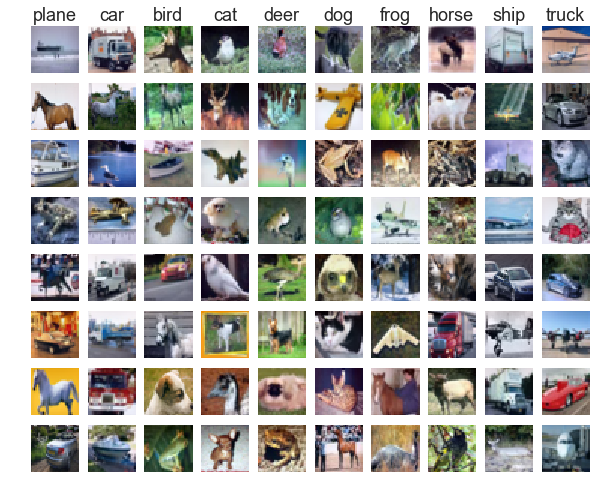

In [44]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

def normalize(img):
    img_max, img_min = np.max(img), np.min(img)
    img = 255.0 *(img - img_min) / (img_max - img_min)
    return img

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

for cls, cls_name in enumerate(classes):
    #loop over all classes;
    idxs = np.where((data['y_test'] != cls) & (y_test_pred == cls))[0]
    #case (1) wrong prediction [false positive]
    idxs_2 = np.where((data['y_test'] == cls) & (y_test_pred != cls))[0]
    #case (2) wrong classification [false negative]
    print(cls_name)
    print('--------')
    #precision = true positives(class_{i}) / (true positives + false positives)
    #recall    = true positives(class_{i}) / (true positives + false negatives)
    true_postives  = np.where((data['y_test'] == cls) & (y_test_pred == cls))[0]
    true_negatives = np.where((data['y_test'] != cls) & (y_test_pred != cls))[0]
    
    false_positives = np.where((data['y_test'] != cls) & (y_test_pred == cls))[0]
    false_negatives = np.where((data['y_test'] == cls) & (y_test_pred != cls))[0]
    
    print("Precision = ", len(true_postives) / (len(true_postives) + len(false_positives)))
    print("Recalll   = ", len(true_postives) / (len(true_postives) + len(false_negatives)))
    print('========')
    #find examples where the prediction matches a specific class
    #BUT: the ground truth is for a different class
    samples = min(examples_per_class, len(idxs))
    idxs = np.random.choice(idxs, samples, replace=False)
    #try and choose '8' examples
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(normalize(data['X_test'][idx]).transpose((1,2,0)).astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

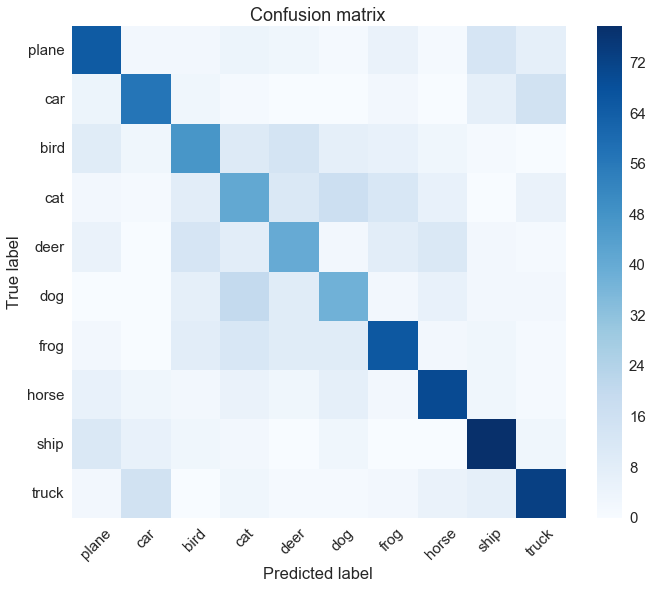

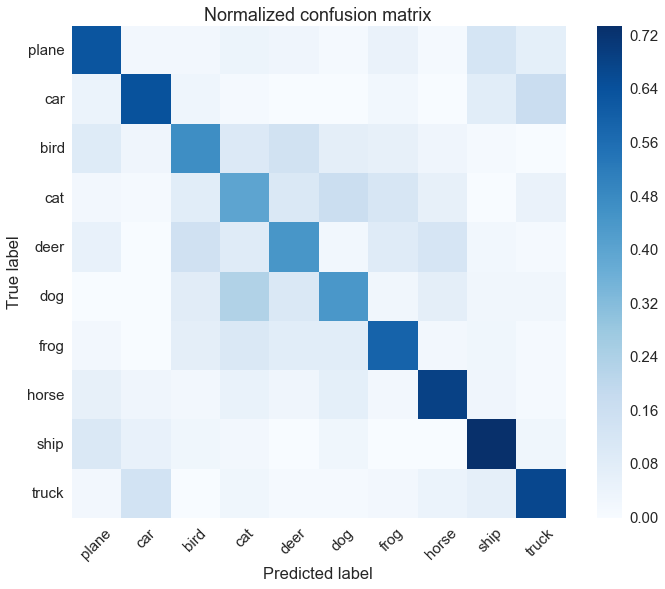

In [45]:
from sklearn.metrics import confusion_matrix

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


y_test = data['y_test'] 
cm = confusion_matrix(y_test, y_test_pred)

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=None):
    if labels is None:
        labels = list(range(len(cm)))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.grid(b='off')
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plot_confusion_matrix(cm, labels=classes)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure()
plot_confusion_matrix(cm_normalized, title="Normalized confusion matrix", labels=classes)